<a href="https://colab.research.google.com/github/danielthomas06/Food101---DeepLearning/blob/main/04_Transfer_Learning_Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow: Feature extraction

Transfer learning is taking advantage of a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture to work on our problems
2. Can use the model to work on our problem which are already learned patterns on dataset similar as ours.

In [ ]:
!nvidia-smi

Sat Jun 12 06:58:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###Downloading and becoming one with the data



In [ ]:
# Get data (10% of the food data)
import zipfile

#DOwnload the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip  the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-12 06:58:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.250.81.208, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2021-06-12 06:58:53 (159 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images '{dirpath}'.")

There are 2 directories and 0 images '10_food_classes_10_percent'.
There are 10 directories and 0 images '10_food_classes_10_percent/train'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images '10_food_classes_10_percent/train/hamburger'.
There are 10 director

### Create data loaders (preparing the data)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE= (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10 = train_datagen.flow_from_directory(train_dir,
                                                  target_size=IMG_SHAPE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (Things to run while our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the popular callbacks:

* Tracking experiments with TensorBoard
* Model Checkpointing
* Early stopping from training

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name+"/"+ experiment_name+"/"+datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Creating models using TensorFlow Hub

Now we can use majority of model's layers are going to come from TensorFlow Hub.

In [ ]:
#Let's comparing the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime


In [ ]:
IMG_SHAPE + (3,)

(224, 224, 3)

In [ ]:
#Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  #Download the pretrained model and save it as keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMG_SHAPE+(3,)) #Freeze the already learned patterns
  #Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


###Create resnet TensorFlow Hub Feature Extarction model

In [ ]:
#Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Compile the resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])


In [ ]:
#Fit the resnet model
resnet_history = resnet_model.fit(train_data_10,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10),
                                  validation_data=test_data,
                                 validation_steps = len(test_data),
                                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/12062021-065906
Epoch 1/5
24/24 [==============================] - 52s 818ms/step - loss: 1.9299 - accuracy: 0.3800 - val_loss: 1.1633 - val_accuracy: 0.6356
Epoch 2/5
24/24 [==============================] - 16s 699ms/step - loss: 0.8947 - accuracy: 0.7267 - val_loss: 0.8446 - val_accuracy: 0.7344
Epoch 3/5
24/24 [==============================] - 16s 700ms/step - loss: 0.6269 - accuracy: 0.8173 - val_loss: 0.7513 - val_accuracy: 0.7556
Epoch 4/5
24/24 [==============================] - 16s 703ms/step - loss: 0.4836 - accuracy: 0.8680 - val_loss: 0.7060 - val_accuracy: 0.7640
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.3870 - accuracy: 0.9027 - val_loss: 0.6667 - val_accuracy: 0.7832


In [ ]:
# Let's create a function to plot loss curves.. 
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label = "training loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #PLot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

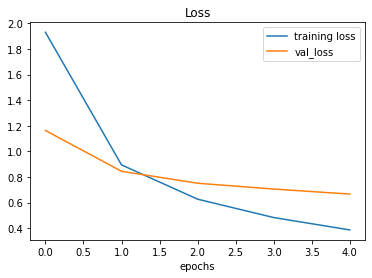

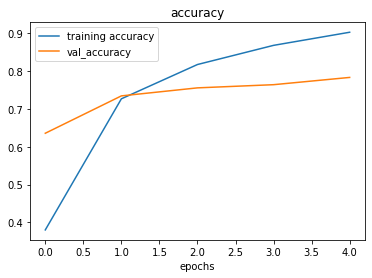

In [ ]:
plot_loss_curves(resnet_history)

### Creating Efficient Net model

In [ ]:
#Creating efficient B0 model
effnet_model = create_model(model_url=effnet_url,
                            num_classes=10)

#Compile effnet model
effnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

effnet_history = effnet_model.fit(train_data_10,
                                  epochs=5,
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/12062021-070114
Epoch 1/5
24/24 [==============================] - 28s 847ms/step - loss: 1.8479 - accuracy: 0.4480 - val_loss: 1.3246 - val_accuracy: 0.7172
Epoch 2/5
24/24 [==============================] - 16s 669ms/step - loss: 1.0765 - accuracy: 0.7613 - val_loss: 0.8747 - val_accuracy: 0.8088
Epoch 3/5
24/24 [==============================] - 15s 663ms/step - loss: 0.7595 - accuracy: 0.8333 - val_loss: 0.7037 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 16s 672ms/step - loss: 0.6110 - accuracy: 0.8560 - val_loss: 0.6161 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 15s 663ms/step - loss: 0.5150 - accuracy: 0.8947 - val_loss: 0.5634 - val_accuracy: 0.8604


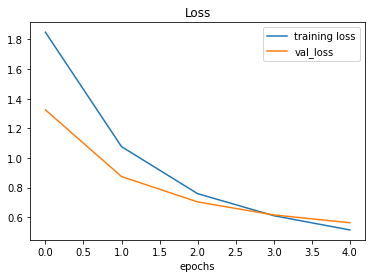

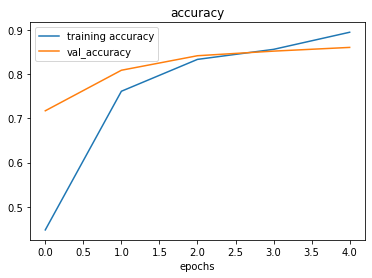

In [ ]:
plot_loss_curves(effnet_history)

In [ ]:
#Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF hub feature extraction model" \
 --one_shot

2021-06-12 07:16:39.126705: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

TensorBoard experminets are uploaded publicly at https://tensorboard.dev/experiment/nVi16bNJQ9udQyG39MjseQ/